# Study of the Competencies of primary schools in Catalonia focusing on the nature of the centre




The aim of this section of the project is to analyze what roles public and private schools play at Catalonia.
In order to do so, I will
1. Understand how schools are distributed in Catalonia, depending on the nature of the centre,
2. Compare private and public schools in educational achivement, preferably differentiating between subjects
3. Correlate the school achievement in private schools with the expenditure in them, both in time, and spatially.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
import seaborn as sns
import pprint
from sodapy import Socrata
import os

## Database- 6e de primaria

In [3]:
# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "LvvKUfbMJLH9IdgS7C4hXbeye")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("rk5x-gny6",limit=1000000)

# Convert to pandas DataFrame
comp = pd.DataFrame.from_records(results)

# Modify what it is wrong in the dataframe:
comp['genere'] = comp['genere'].replace({'Home': 'H', 'Dona': 'D'})

## Database expenditure on private schools

In [4]:
import pandas as pd
from sodapy import Socrata

# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "LvvKUfbMJLH9IdgS7C4hXbeye")

# Fetch the first 2000 results as JSON and convert them to a Python list of dictionaries
results = client.get("8spq-9nx7",limit=10000)

# Convert to pandas DataFrame
gastos = pd.DataFrame.from_records(results)

# We only want to analyze Primary Schools
gprim= gastos.dropna(subset=['unitats_concertades_pri'])

## 1. Distribution of private and public schools in Catalonia
### Gender

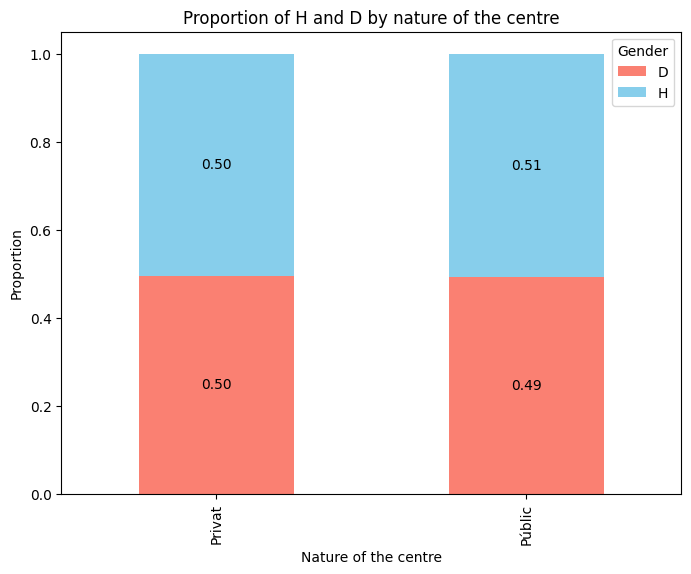

In [5]:
# Comparison of gender

import matplotlib.pyplot as plt

# Step 1: Calculate the counts of "H" and "D" for each category
counts = comp.groupby(['naturalesa', 'genere']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Customize the plot
plt.title('Proportion of H and D by nature of the centre')
plt.xlabel('Nature of the centre')
plt.ylabel('Proportion')
plt.legend(title='Gender')

# Adding proportion labels on each bar
for i, (index, row) in enumerate(proportions.iterrows()):
    cumulative_height = 0  # Keeps track of where to place each label
    for j, proportion in enumerate(row):
        cumulative_height += proportion
        ax.text(i, cumulative_height - proportion / 2, f"{proportion:.2f}", ha='center', va='center', color='black')

plt.show()


### Spatial distribution

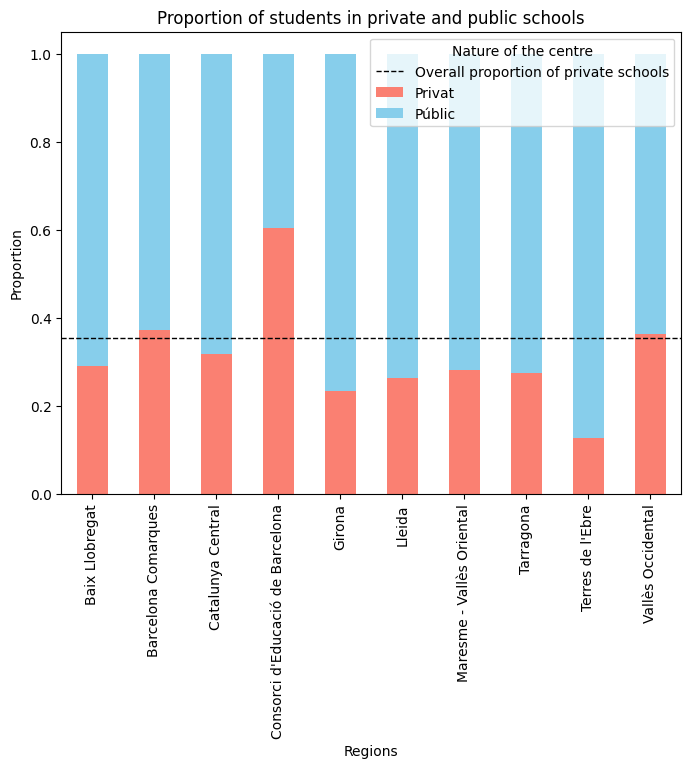

In [6]:
# Step 1: Calculate the counts of "Privat" and "Públic" for each category
counts = comp.groupby(['area_territorial', 'naturalesa']).size().unstack(fill_value=0)

# Step 2: Calculate proportions by dividing by row sums
proportions = counts.div(counts.sum(axis=1), axis=0)

# Step 3: Plot a stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 6))

# Calculate the overall counts of each 'naturalesa' category (e.g., private and public) across all areas
ccounts = comp['naturalesa'].value_counts()

# Calculate the overall proportion for "Privat" as a single value
hvalue = ccounts['Privat'] / (ccounts['Privat'] + ccounts['Públic'])

# Draw a single horizontal line for the overall "Privat" proportion
ax.axhline(y=hvalue, color='black', linestyle='--', linewidth=1, label='Overall proportion of private schools')

# Customize the plot
plt.title('Proportion of students in private and public schools')
plt.xlabel('Regions')
plt.ylabel('Proportion')
plt.legend(title='Nature of the centre')
plt.show()


#### Let's try with maps

In [7]:
mncps = gpd.read_file("../data/Municipis/mncps.shp")
mncps.rename(columns={'NOMREGIO': 'area_territorial', 'NOMMUNI': 'municipi'}, inplace=True)

regions = gpd.read_file("../data/Municipis/regions.shp")
regions.rename(columns={'NOMREGIO': 'area_territorial'}, inplace=True)

# Add region code
regions['code'] = range(len(regions))

# Add the coordinates to the dataframe
comp2 = comp.merge(regions, on='area_territorial')

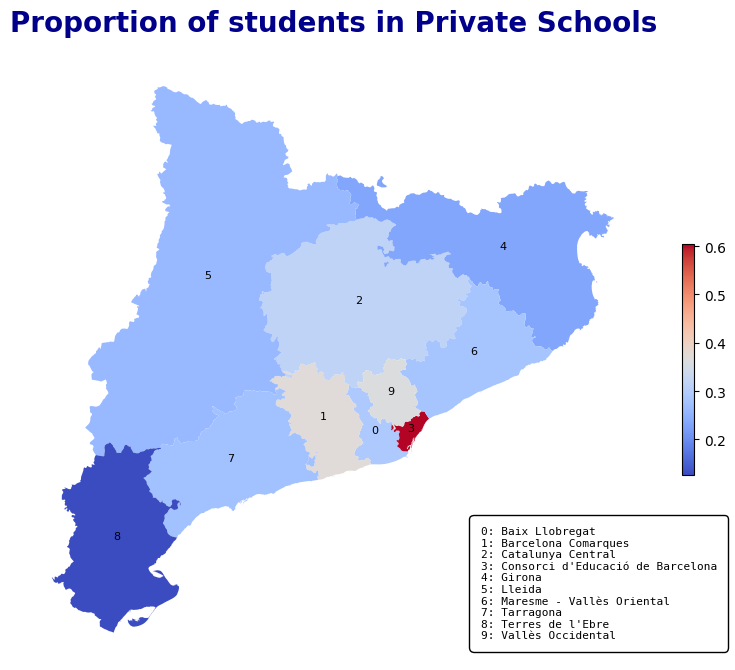

In [8]:
# Merge proportions and regions to form proportions_gdf
proportions2 = proportions.merge(regions, on='area_territorial')
proportions_gdf = gpd.GeoDataFrame(proportions2, geometry='geometry')

# Plot the map with regions colored by 'Privat'
fig, ax = plt.subplots(figsize=(10, 10))
proportions_gdf.plot(column='Privat', 
                     ax=ax, 
                     legend=True, 
                     cmap='coolwarm',  
                     missing_kwds={"color": "lightgrey", "label": "No data"},
                     legend_kwds={'shrink': 0.3})  

# Add region codes as text on the map
for idx, row in proportions_gdf.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
            row['code'], fontsize=8, ha='center', color='black')

# Create a string for the mapping of codes to region names
legend_text = "\n".join([f"{row['code']}: {row['area_territorial']}" for _, row in proportions_gdf.iterrows()])

# Create a box for the legend
legend_box = TextArea(legend_text, textprops=dict(fontsize=8, family='monospace'))
anchored_box = AnchoredOffsetbox(loc='lower center',  # Place at the bottom center
                                 child=legend_box,
                                 pad=0.5,
                                 frameon=True,  # Enable the box frame
                                 bbox_to_anchor=(0.7, 0.2),  # Offset below the plot
                                 bbox_transform=fig.transFigure,  # Use figure coordinates
                                 borderpad=0.5)
anchored_box.patch.set_boxstyle("round,pad=0.3")  # Rounded corners for the box
ax.add_artist(anchored_box)

# Customize the title
plt.title('Proportion of students in Private Schools', 
          fontsize=20,         
          fontweight='bold',   
          color='darkblue',    
          loc='center',        
          pad=20)              

plt.axis('off')  # Hide axes
plt.show()



In [9]:
proportions_gdf

,area_territorial,Privat,Públic,geometry,code
0,Baix Llobregat,0.290053,0.709947,"POLYGON ((416496.693 4568594.713, 416494.027 4...",0
1,Barcelona Comarques,0.372619,0.627381,"MULTIPOLYGON (((395328.020 4563737.970, 395280...",1
2,Catalunya Central,0.316417,0.683583,"MULTIPOLYGON (((374079.248 4610945.985, 374076...",2
3,Consorci d'Educació de Barcelona,0.604634,0.395366,"MULTIPOLYGON (((430672.760 4576094.500, 430638...",3
4,Girona,0.232353,0.767647,"MULTIPOLYGON (((471904.065 4651635.777, 471575...",4
5,Lleida,0.261943,0.738057,"MULTIPOLYGON (((304547.841 4575431.598, 304265...",5
6,Maresme - Vallès Oriental,0.281438,0.718562,"MULTIPOLYGON (((440741.854 4591175.189, 440657...",6
7,Tarragona,0.274780,0.725220,"MULTIPOLYGON (((319540.469 4547243.953, 319962...",7
8,Terres de l'Ebre,0.126486,0.873514,"MULTIPOLYGON (((295273.291 4497586.320, 295229...",8
9,Vallès Occidental,0.363518,0.636482,"MULTIPOLYGON (((427306.316 4588229.172, 427266...",9


## 2. Educational achievement

In [10]:
# Calculate mean grades, not french
comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']] = comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']].apply(pd.to_numeric, errors='coerce')
comp2['mean_grade'] = comp2[['pcat', 'pmat', 'pcast', 'pmed', 'pang']].mean(axis=1)


Comparison of grades over regions

In [11]:
def mean_map(year):
    year = str(year)
    means_by_area = comp2[comp2['any'] == year].groupby('area_territorial', as_index=False)['mean_grade'].mean()
    means_by_area = means_by_area.merge(regions, on='area_territorial')
    means_by_area = gpd.GeoDataFrame(means_by_area, geometry='geometry')

    # Plot the map with regions colored by 'mean_grade'
    fig, ax = plt.subplots(figsize=(10, 10))
    means_by_area.plot(column='mean_grade', 
                        ax=ax, 
                        legend=True, 
                        cmap='coolwarm_r',  
                        missing_kwds={"color": "lightgrey", "label": "No data"},
                        legend_kwds={'shrink': 0.3})  

    # Add region codes as text on the map
    for idx, row in proportions_gdf.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                row['code'], fontsize=8, ha='center', color='black')

    # Create a string for the mapping of codes to region names
    legend_text = "\n".join([f"{row['code']}: {row['area_territorial']}" for _, row in proportions_gdf.iterrows()])

    # Create a box for the legend
    legend_box = TextArea(legend_text, textprops=dict(fontsize=8, family='monospace'))
    anchored_box = AnchoredOffsetbox(loc='lower center',  # Place at the bottom center
                                    child=legend_box,
                                    pad=0.5,
                                    frameon=True,  # Enable the box frame
                                    bbox_to_anchor=(0.7, 0.2),  # Offset below the plot
                                    bbox_transform=fig.transFigure,  # Use figure coordinates
                                    borderpad=0.5)
    anchored_box.patch.set_boxstyle("round,pad=0.3")  # Rounded corners for the box
    ax.add_artist(anchored_box)

    # Customize the title
    plt.title('Mean grade in ' + year, 
            fontsize=20,         
            fontweight='bold',   
            color='darkblue',    
            loc='center',        
            pad=20)              

    plt.axis('off')  # Hide axes
    plt.show()



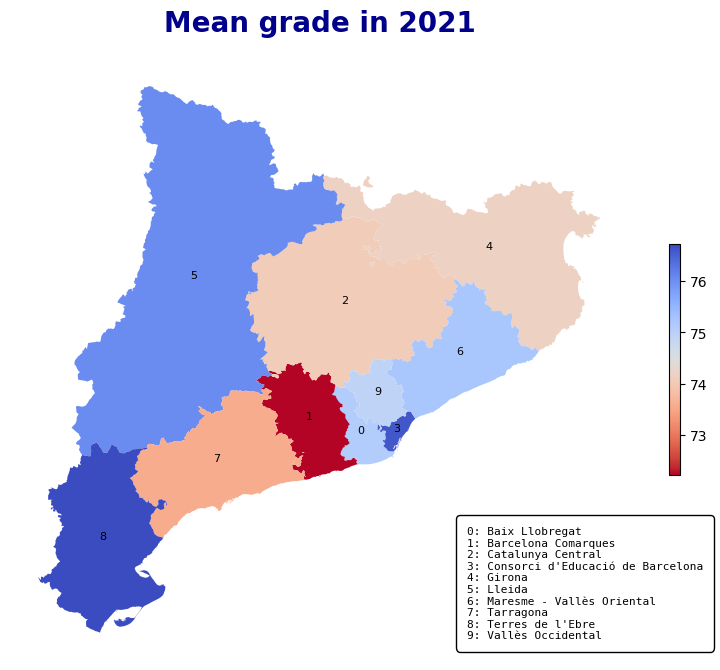

In [12]:
mean_map(2021)

In [13]:
c_priv = comp2[comp2["naturalesa"] == "Privat"].copy()
c_priv.rename(columns={'any': 'curs_escolar'}, inplace=True)

c_pub = comp2[comp2["naturalesa"] == "Públic"].copy()
c_pub.rename(columns={'any': 'curs_escolar'}, inplace=True)

### Comparison Public-Private in 2023

## Achievement-expenditure correlation 

In [15]:
priv_clean = c_priv.dropna(subset=['mean_grade'])


Correlate expenditure with mean grade: data for each region and each year: 5 years*10

In [46]:
# Data preparation
gprim2 = gprim.copy()
gprim2['curs_escolar'] = gprim['curs_escolar'].str.split('-').str[1] #so that they have the same format
# To convert
columns_to_convert = ['brut', 'alumnes_pri', 'alumnes_eso', 'alumnes_batx', 'alumnes_cfpm','alumnes_cfps']

# Aplicar la conversión a todas las columnas en la lista
gprim2[columns_to_convert] = gprim2[columns_to_convert].apply(pd.to_numeric, errors='coerce')



In [57]:
#df_alumnos_total['al_pri_prop']=
#df_alumnos_total['alumnes_pri']/df
df_merged.head(10)

,curs_escolar,area_territorial,brut,alumnes_pri,alumnes_eso,alumnes_batx,alumnes_cfpm,alumnes_cfps,al_total,brut_per_alumne
0,2018,Baix Llobregat,5.782597e+07,13079.0,9331.0,575.0,97.0,59.0,23141.0,2498.853537
1,2018,Barcelona Comarques,2.646596e+07,5999.0,4134.0,69.0,158.0,48.0,10408.0,2542.848251
2,2018,Catalunya Central,3.748634e+07,7695.0,4231.0,486.0,400.0,306.0,13118.0,2857.626024
3,2018,Consorci d'Educació de Barcelona,2.557825e+08,54519.0,39442.0,5326.0,1188.0,1617.0,102092.0,2505.411838
4,2018,Girona,3.275763e+07,7788.0,4854.0,125.0,40.0,0.0,12807.0,2557.790914
5,2018,Lleida,2.652923e+07,5850.0,3575.0,227.0,68.0,218.0,9938.0,2669.474009
6,2018,Maresme - Vallès Oriental,6.956835e+07,15313.0,10650.0,799.0,349.0,435.0,27546.0,2525.533635
7,2018,Tarragona,4.139848e+07,9417.0,6314.0,328.0,326.0,158.0,16543.0,2502.477155
8,2018,Terres de l'Ebre,5.313463e+06,1095.0,856.0,0.0,23.0,0.0,1974.0,2691.724073
9,2018,Vallès Occidental,9.057879e+07,20579.0,14636.0,883.0,399.0,157.0,36654.0,2471.184440


In [64]:
# Expenditure of each area and year
df_gastos = mncps.merge(gprim2,on = 'municipi').groupby(['curs_escolar', 'area_territorial'], as_index=False)['brut'].sum()
# Expenditure/students of each area and year
df_alumnos_total = mncps.merge(gprim2, on='municipi').groupby(['curs_escolar', 'area_territorial'], as_index=False).agg({'alumnes_pri': 'sum', 'alumnes_eso': 'sum', 'alumnes_batx': 'sum', 'alumnes_cfpm' : 'sum','alumnes_cfps': 'sum'})
df_alumnos_total['al_total'] = df_alumnos_total[['alumnes_pri', 'alumnes_eso', 'alumnes_batx', 'alumnes_cfpm','alumnes_cfps']].sum(axis=1)

df_merged = df_gastos.merge(df_alumnos_total, on=['curs_escolar', 'area_territorial'])
df_merged['brut_per_alumne'] = df_merged['brut'] * df_merged['alumnes_pri'] / df_merged['al_total']

# Grades of each area and year
df_grades = priv_clean.groupby(['curs_escolar', 'area_territorial'], as_index = False)['mean_grade'].mean()

df_corrs = df_merged.merge(df_grades, on = ['curs_escolar', 'area_territorial'])

df_corrs2 = df_corrs.copy()
df_corrs2['area_territorial'] = (df_corrs.index % 10).astype(str) + ', ' + df_corrs['area_territorial']

Correlation Coefficient: 0.16


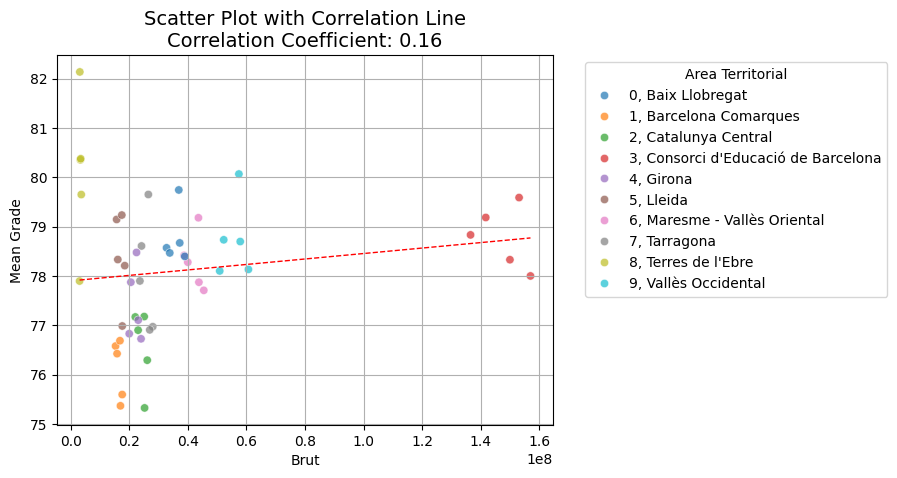

In [65]:
# Calculate the correlation coefficient
corr_coeff = np.corrcoef(df_corrs2['brut_per_alumne'], df_corrs2['mean_grade'])[0, 1]
print(f"Correlation Coefficient: {corr_coeff:.2f}")

# Scatter plot with regression line
sns.scatterplot(data=df_corrs2, x='brut_per_alumne', y='mean_grade', hue='area_territorial', alpha=0.7)

# Add the regression line with thinner and dashed style
sns.regplot(
    data=df_corrs2, 
    x='brut_per_alumne', 
    y='mean_grade', 
    scatter=False, 
    color='red', 
    ci=None,
    line_kws={'linestyle': '--', 'linewidth': 1}  # Dashed line and thinner width
)

# Customize the plot
plt.title(f'Scatter Plot with Correlation Line\nCorrelation Coefficient: {corr_coeff:.2f}', fontsize=14)
plt.xlabel('Brut')
plt.ylabel('Mean Grade')
plt.grid(True)

# Move the legend outside the plot
plt.legend(title='Area Territorial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

/tmp/ipykernel_18020/1899774250.py:71: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



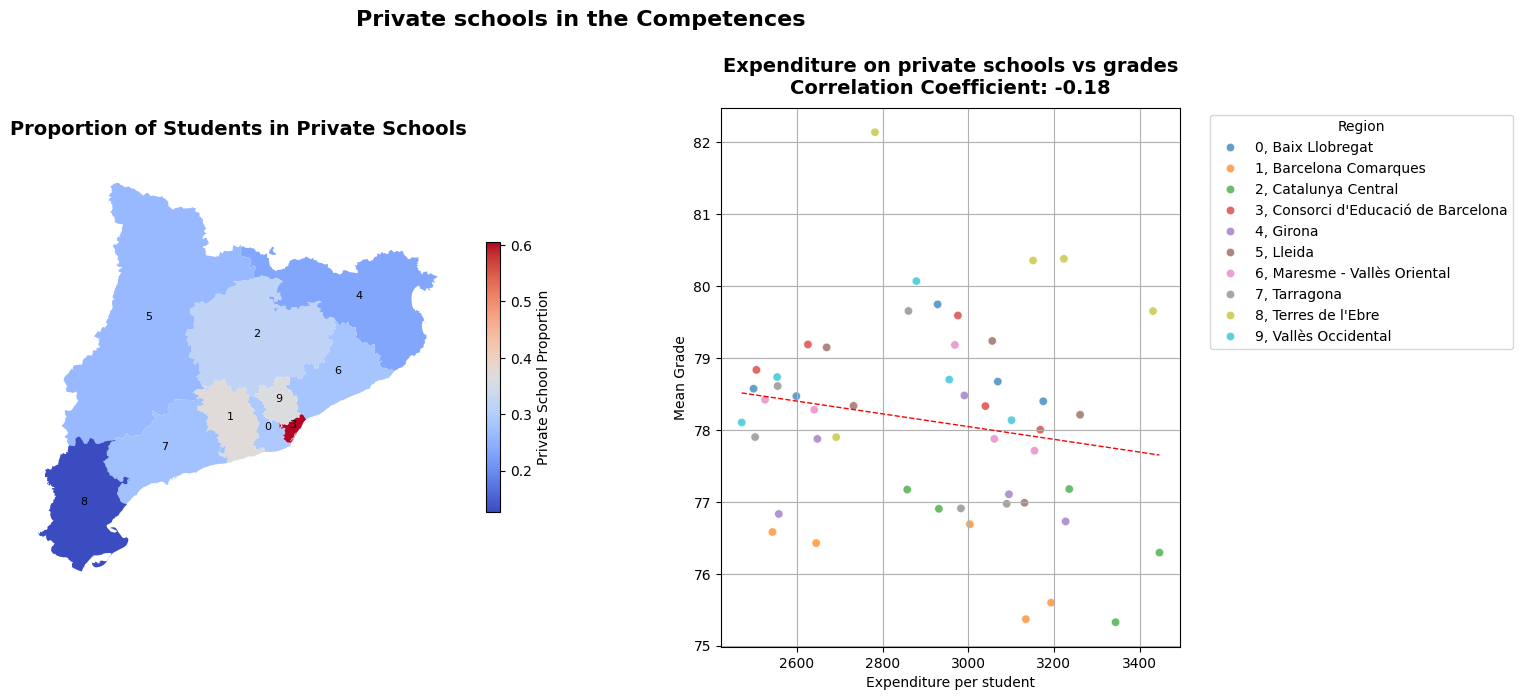

In [63]:
# Define the figure and grid layout
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.3)  # Adjust width ratios and spacing

# --- Plot 1: Map ---
ax1 = fig.add_subplot(gs[0, 0])

# Proportion map
proportions2 = proportions.merge(regions, on='area_territorial')
proportions_gdf = gpd.GeoDataFrame(proportions2, geometry='geometry')

proportions_gdf.plot(
    column='Privat',
    ax=ax1,
    legend=True,
    cmap='coolwarm',
    missing_kwds={"color": "lightgrey", "label": "No data"},
    legend_kwds={'shrink': 0.5, 'label': 'Private School Proportion'}
)

# Add region codes as text on the map
for idx, row in proportions_gdf.iterrows():
    ax1.text(row.geometry.centroid.x, row.geometry.centroid.y, 
             row['code'], fontsize=8, ha='center', color='black')

# Customize title and remove axes
ax1.set_title('Proportion of Students in Private Schools', 
              fontsize=14, fontweight='bold', pad=10)
ax1.axis('off')

# --- Plot 2: Scatter Plot ---
ax2 = fig.add_subplot(gs[0, 1])


# Calculate the correlation coefficient
corr_coeff = np.corrcoef(df_corrs2['brut_per_alumne'], df_corrs2['mean_grade'])[0, 1]

# Scatter plot with regression line
sns.scatterplot(
    data=df_corrs2, 
    x='brut_per_alumne', 
    y='mean_grade', 
    hue='area_territorial', 
    alpha=0.7, 
    ax=ax2
)

# Add the regression line with thinner and dashed style
sns.regplot(
    data=df_corrs2, 
    x='brut_per_alumne', 
    y='mean_grade', 
    scatter=False, 
    color='red', 
    ci=None,
    line_kws={'linestyle': '--', 'linewidth': 1}  # Dashed line and thinner width
)


# Customize scatter plot
ax2.set_title(f'Expenditure on private schools vs grades\nCorrelation Coefficient: {corr_coeff:.2f}', fontsize=14, fontweight='bold', pad=10)
ax2.set_xlabel('Expenditure per student')
ax2.set_ylabel('Mean Grade')
ax2.grid(True)

# Move the legend outside
ax2.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Final Layout Adjustments ---
plt.suptitle('Private schools in the Competences', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Show the combined figure
plt.show()